In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as sp
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 10 # 25 # 50
d_H = 2 # 10
width = 1024  # 1024
bias = False
n_steps = 10000 # 2000
base_lr = 5.0e-3

SEED = 42
num = 500
N_b = 1000

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/1d/')

In [8]:
set_random_seeds(SEED)
key = jax.random.PRNGKey(SEED)

key_1, key_2 = jax.random.split(key, num=2)

# 1. Initial Density $\tau_0$

If $X \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2} \right)$, then we have that $Y = \arccos \left(\sqrt{X} \right) \sim \tau_0$ where $$d\tau_0(\theta) = \frac{2}{B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right)} \cos(\theta)^{d_H - 1} \sin(\theta)^{d_\perp - 1} d\theta$$

In [9]:
@jit
def tau_0_density(theta, d_H=d_H, input_dim=input_dim):
    d = input_dim
    return 2 * (jnp.cos(theta) ** (d_H - 1)) * (jnp.sin(theta) ** (d-d_H -1)) / sp.beta(d_H/2, (d-d_H)/2)

In [10]:
m = width 
d = input_dim

initial_cs = jnp.sign(jax.random.uniform(key=key, minval=-1., maxval=1.0, shape=[width]))
initial_thetas = jnp.arccos(jnp.sqrt(jax.random.beta(key, d_H/2, (d-d_H)/2, shape=[width])))
signs = jnp.copy(initial_cs)

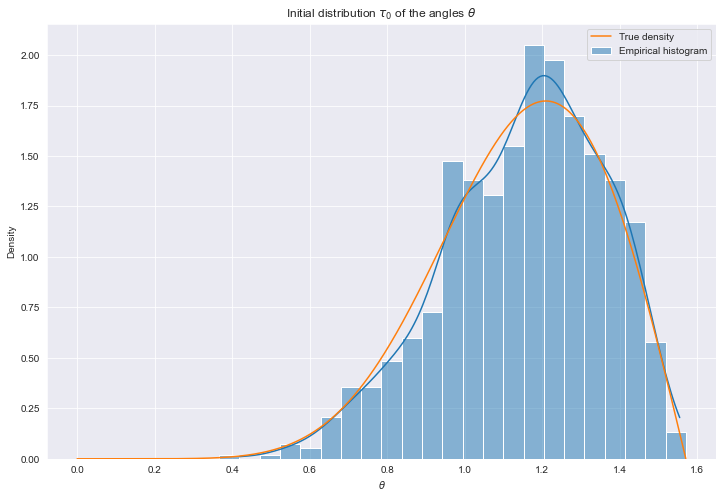

In [11]:
theta_grid = jnp.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\theta$'])
data['$\\theta$'] = initial_thetas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\theta$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

### 1.1 Other distributions test

In [12]:
omegas = jnp.arccos(jnp.sqrt(jax.random.beta(key, d_H/2, (d-d_H)/2, shape=[N_b])))
qs = jnp.sqrt(jax.random.beta(key, 1/2, (d_H - 1)/2, shape=[1, 2*N_b]))
vs = jnp.sqrt(jax.random.beta(key, 1/2, (d-d_H-1)/2, shape=[1, 2*N_b]))
bernouillis = jnp.sign(jax.random.uniform(key, minval=-1., maxval=1.0, shape=[2, 2*N_b]))
rs = (qs * bernouillis[0, :]).reshape(-1)
us = (vs * bernouillis[1, :]).reshape(-1)

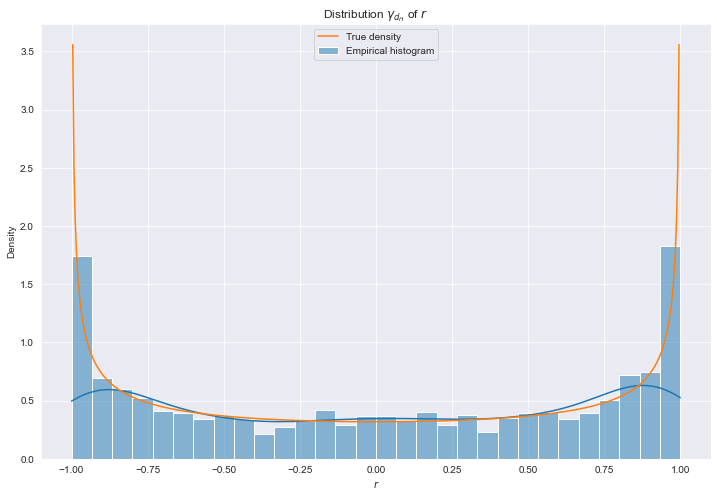

In [13]:
u_grid = jnp.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$r$'])
data['$r$'] = rs

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$r$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d_H-3)/2) / sp.beta(1/2, (d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_H}$ of $r$')
plt.legend()
plt.show()

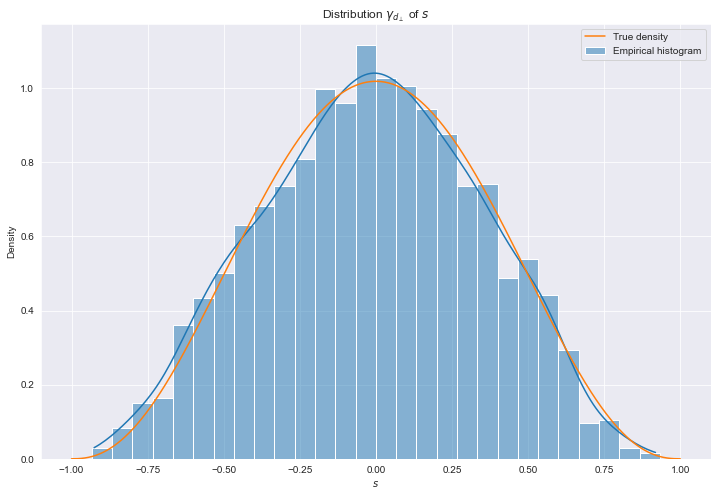

In [14]:
r_grid = jnp.linspace(start=-1., stop=1., num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['s$'])
data['$s$'] = us

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$s$', stat='density', kde=True, binrange=(-1., 1.), bins=30, 
             label='Empirical histogram')
plt.plot(u_grid, (1 - u_grid**2)**((d-d_H-3)/2) / sp.beta(1/2, (d-d_H-1)/2), color=colors[1], label='True density')
plt.title('Distribution $\gamma_{d_\perp}$ of $s$')
plt.legend()
plt.show()

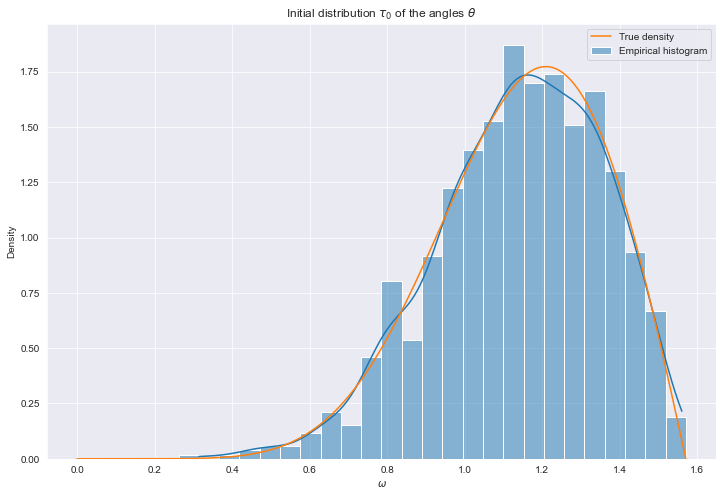

In [15]:
theta_grid = jnp.linspace(start=0., stop=np.pi/2, num=num, endpoint=True)
colors = sns.color_palette()

data = pd.DataFrame(columns=['$\\omega$'])
data['$\\omega$'] = omegas

plt.figure(figsize=(12, 8))
sns.histplot(data, x='$\\omega$', stat='density', kde=True, binrange=(0., np.pi/2), bins=30, 
             label='Empirical histogram')
plt.plot(theta_grid, tau_0_density(theta_grid), color=colors[1], label='True density')
plt.title('Initial distribution $\\tau_0$ of the angles $\\theta$')
plt.legend()
plt.show()

## 1.A. Tests at initialization

### A.I) Squared target average

In theory, the initial squared loss is $(1/2) \mathbb{E}[||y_H||^2]$ because the predictor is 0. After some computation, this should be equal to $d_H/2$. An integral appearing in this computation is 
\begin{align*}
    \int_\omega \cos(\omega)^2 d\tilde{\gamma}(\omega) =& d_H/d
\end{align*}
We will check that our sampling strategy yields the correct result.

In [16]:
print('d_H/d = {:.5f}'.format(d_H/input_dim))
val = jnp.sum(jnp.cos(omegas) **2 ) / N_b
print('Estimated value via MC sampling: {:.5f}'.format(val))

d_H/d = 0.20000
Estimated value via MC sampling: 0.19971


We will compute the inital $f(\tau_{m,0}; \omega)$ for $\omega$ first in a grid line over $[0, \pi/2]$ and second for $\omega$ sampled according to the initial distribution.

# 2. Simulation of the dynamic

## 2.1 Parameterizing the problem

Consider functions parameterized by $\tau = \tau^+ - \tau^- \in \mathcal{M}([0, \pi/2])$ where $\tau^\pm \in \mathcal{M}_+([0, \pi/2])$ as 
\begin{align}
    \tilde{f}(\tau; \varphi) &=  \int_{\theta} \tilde{\phi} (\theta; \varphi) d\tau(\theta)
\end{align}
where 
\begin{align}
    \tilde{\phi}(\theta; x) = \int_{r,s} \sigma \Big(\cos(\theta) ||x_H|| r +  \sin(\theta) ||x_\perp|| s\Big) d\tilde{\gamma}_{d_H}(r) d \tilde{\gamma}_{d_\perp}(s)
\end{align}
where $d\gamma_{d_H}$ and $d\gamma_{d_\perp}$ are defined below:
\begin{align}
    d\gamma_{d_H}(r) &= (1 - r^2)^{(d_H-3)/2} \\
    d\gamma_{d_\perp}(s) &= (1 - s^2)^{(d_\perp-3)/2}
\end{align}
This can be re-written
\begin{align}
    \tilde{\phi}(\theta; \varphi) &= \int_{r,s} \psi(r,s; \theta, \phi) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s) \\
    \psi(r, s; \theta, \varphi) &= \sigma \Big(\cos(\theta) \cos(\varphi)  r +  \sin(\theta) \sin(\varphi) s\Big)
\end{align}

In [17]:
@jit
def psi(r, s, theta, phi):
    return jnp.maximum(jnp.cos(theta) * (jnp.cos(phi) * r) + jnp.sin(theta) * (jnp.sin(phi) * s), 0)

## 2.2 Dynamic and approximation of the reaction and drift terms

The gradient flow equations are as follows for any pair of (weight, position) indexed by $j$:
\begin{align}
    c_j'(t) &= 2 \varepsilon_j c_j(t) G_t(\theta_j(t)) \\
    \theta_j'(t) &= \varepsilon_j V_t(\theta_j(t))
\end{align}
which induce the following discretized updates:
\begin{align}
    c_j(k+1) &= \left(1 + 2 \eta \varepsilon_j G_t(\theta_j(k)) \right) c_j(k)  \\
    \theta_j(k+1) &= \theta_j(k) + \eta \varepsilon_j V_t(\theta_j(k))
\end{align}
where $\varepsilon_j$ is the initial sign of the $j$-th particle (i.e. $\varepsilon_j = c_j(0)$), and the drift term $V_t$ and the reaction term $G_t$ are
\begin{align}
    G_t(\theta) &= d \int_{\omega} R_t(\omega) \int_{r,s} \psi(r,s; \theta, \varphi) d\tilde{\gamma}(\varphi) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s) \\
    V_t(\theta) &= G_t'(\theta) = d \int_{\varphi} R_t(\varphi) \int_{r,s} \chi(r,s; \theta, \varphi)  d\tilde{\gamma}(\varphi) d\tilde{\gamma}_{d_H}(r) d\tilde{\gamma}_{d_\perp}(s)
\end{align}
where 
\begin{align}
\chi(r,s; \theta, \varphi) :&= \sigma' \Big( \cos(\theta) \cos(\varphi)  r +  \sin(\theta) \sin(\varphi) s\Big) \Big[-\sin(\theta) \cos(\varphi)  r +  \cos(\theta) \sin(\varphi) s \Big] \\
    d\tilde{\gamma}(\varphi) &= d\tau_0(\varphi) \\
    R_t(\varphi) &= \cos(\varphi) - \tilde{f}(\tau_{m,t}; \varphi) \\
\end{align}
with the discretization
\begin{align}
    \tau_{m,t} &= \frac{1}{m} \sum_{j=1}^m c_j(t) \delta_{\theta_j(t)} \\
    \tilde{f}(\tau_{m,t}; \varphi) &= \frac{1}{m} \sum_{j=1}^m c_j(t) \tilde{\phi}(\theta_j(t); \varphi)
\end{align}

We rely on Monte-Carlo sampling to estimate the integrals defining $V_t$ and $G_t$, defining $\chi = \partial_\theta \psi$:
\begin{align}
    V_t(\theta) \simeq \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \chi(\theta, \Omega_i; R_i, S_i) \\
    G_t(\theta) \simeq \frac{d }{N_b} \sum_{i=1}^{N_b} R_t(\Omega_i) \psi(\theta, \Omega_i; R_i, S_i)
\end{align}
where we have sampled
\begin{align}
    \Phi_i &= \arccos(\sqrt{\Lambda_i}), \qquad \Lambda_i \sim B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \\
    R_i &= \epsilon_i \sqrt{P_i}, \qquad P_i \sim B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \\
    S_i &= \epsilon_i \sqrt{Q_i}, \qquad Q_i \sim B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right) \\
    \epsilon_i &\sim \mathcal{U}(\{-1, 1\})
\end{align}

In [18]:
@jit
def chi(r, s, theta, phi):
    return ((1 + jnp.sign(jnp.cos(theta) * (jnp.cos(phi) * r) + jnp.sin(theta) * (jnp.sin(phi) * s)))/2 * 
            (jnp.cos(theta) * (jnp.sin(phi) * s) - jnp.sin(theta) * (jnp.cos(phi) * r)))

## 2.3 Simulating the dynamic by samling at each iteration

We use the following procedure: $c_j(0)$ and $\theta_j(0)$ being suitably initialized, at each iteration $k$, we do:
1. draw $N_b$ samples $(\Lambda_i, P_i, Q_i, \epsilon_i, P^\prime_i, Q^\prime_i, \epsilon^\prime_i)$ from $B \left(\frac{d_H}{2}, \frac{d_\perp}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_H-1}{2}\right) \otimes B \left(\frac{1}{2}, \frac{d_\perp-1}{2}\right) \otimes \mathcal{U}(\{-1, +1\})$
2. compute the vectors $(\Phi, R, S, R^\prime, S^\prime) = (\arccos(\sqrt{\Lambda_i}), \epsilon_i \sqrt{P_i}, \epsilon_i \sqrt{Q_i}, \epsilon^\prime_i \sqrt{P^\prime_i}, \epsilon^\prime_i \sqrt{Q^\prime_i})_{i \in [1, N_b]}$

To avoid having multiple different samplings, we put the termm $\cos(\omega)$ inside the integral defining $R_t(\omega)$ and thus consider $G_t$ and $V_t$ as integrals over the $5$ variables $(\omega, r, s, r', s')$. Being carefull with the constants, we find:
\begin{align*}
    G_t(\theta) &= d \int_{\varphi, r, s, r', s'} \frac{\psi(r,s; \theta, \varphi)}{m} \sum_{j=1}^m \Big(\cos(\varphi) - c_j  \psi(r', s'; \theta_j, \varphi) \Big) d\tilde{\gamma}(\varphi) (d\tilde{\gamma}_{d_H})^2(r,r'))(d\tilde{\gamma}_{d_\perp})^2(s,s') \\
     V_t(\theta) &= d \int_{\varphi, r, s, r', s'} \frac{\chi(r,s; \theta, \varphi)}{m} \sum_{j=1}^m \Big(\cos(\varphi) - c_j  \psi(r', s'; \theta_j, \varphi) \Big) d\tilde{\gamma}(\varphi) (d\tilde{\gamma}_{d_H})^2 (r,r')(d\tilde{\gamma}_{d_\perp})^2(s,s')
\end{align*}
which allows for easy Monte-Carlo estimation through sampling from those 5 distributions.

3. Define $\mathbf{\Psi}$ and $\mathbf{\chi}$ the matrices such that 
\begin{align*}
    \mathbf{\Psi}_{j,i} &= \psi(R_i, S_i; \theta_j, \Phi_i) \\
    \mathbf{\tilde{\Psi}}_{j,i} &= \psi(R'_i, S'_i; \theta_j, \Phi_i) \\
    \chi_{j,i} &= \chi(R_i, S_i; \theta_j, \Phi_i)
\end{align*}

The update rules are given for any $j \in [1, m]$ by:
\begin{align*}
    c_j(k+1) &= \left(1 + 2 \eta \hat{G}_k(\theta_j(k)) \right) c_j(k)  \\
    \theta_j(k+1) &= \theta_j(k) + \eta \hat{V}_k(\theta_j(k))
\end{align*}
but they can be expressed matricially.

4. Use the following update rules for the vectors $c = (c_j)_j$ and $\theta = (\theta_j)_j$:
\begin{align*}
    c(k+1) &= (1 + 2 \eta \hat{G}_k) \odot c(k) \\
    \theta(k+1) &= \theta(k) + \eta \hat{V}_k
\end{align*}
where 
\begin{align*}
    \hat{G}_k &= \frac{d}{N_b} \mathbf{\Psi} \left(\cos(\Phi) - \frac{1}{m} \mathbf{\tilde{\Psi}}^\top c(k) \right) \\
    \hat{V}_k &= \frac{d}{N_b} \mathbf{\chi} \left(\cos(\Phi) - \frac{1}{m} \mathbf{\tilde{\Psi}}^\top c(k) \right)
\end{align*}
5. Add the $[c_j(k+1)]_j$ and $[\theta_j(k+1)]_j$ to the list of previous updates

As for the loss computation, it is given by 
\begin{align*}
    L_k =& \frac{2}{d} \tilde{L}_k \\
    \tilde{L}_k =& \frac{d_H}{d} - \frac{2}{m N_b} c(k)^\top \mathbf{\Psi} \cos(\Phi) + \frac{1}{m^2 N_b} c(k)^\top \mathbf{\Psi} \mathbf{\tilde{\Psi}}^\top c(k)
\end{align*}

In [19]:
@jit
def monte_carlo_samples(key):
    keys = jax.random.split(key, num=4)
    phis = jnp.arccos(jnp.sqrt(jax.random.beta(keys[0], d_H/2, (d-d_H)/2, shape=[1, N_b])))
    
    rs = jnp.sqrt(jax.random.beta(keys[1], 1/2, (d_H - 1)/2, shape=[2, N_b]))
    ss = jnp.sqrt(jax.random.beta(keys[2], 1/2, (d-d_H-1)/2, shape=[2, N_b]))
    
    bernouillis = jnp.sign(jax.random.uniform(keys[3], minval=-1., maxval=1.0, shape=[4, N_b]))
    
    rs = rs * bernouillis[:2, :]
    ss = ss * bernouillis[2:, :]
    
    return keys[3], phis, rs, ss

In [20]:
@jit
def forward(phis, rs, ss, cs_k, thetas_k):
    # matrices and vectors at step k
    psi_mat = psi(rs[[0], :], ss[[0], :], thetas_k.reshape(-1, 1), phis)
    psi_tilde_mat_T = jnp.transpose(psi(rs[[1], :], ss[[1], :], thetas_k.reshape(-1, 1), phis))

    # residuals at step k
    f_tilde_k = jnp.matmul(psi_tilde_mat_T, cs_k) / width
    residuals_k = jnp.cos(phis.reshape(-1)) - f_tilde_k

    # loss at step k
    f_k = jnp.matmul(jnp.transpose(psi_mat), cs_k) / width
#    loss_k = 0.5 * (d_H / input_dim - 
#                    (2 * jnp.inner(jnp.cos(phis.reshape(-1)),  f_tilde_k) / N_b) + 
#                    (jnp.inner(f_k, f_tilde_k)) / N_b)

    loss_k = 0.5 * (jnp.sum(jnp.cos(phis)**2) / N_b - 
                    (2 * jnp.inner(jnp.cos(phis.reshape(-1)),  f_k) / N_b) + 
                    (jnp.inner(f_k, f_tilde_k)) / N_b)
    
    return psi_mat, residuals_k, loss_k

In [21]:
@jit
def train_step(key, cs_k, thetas_k):
    
    # matrices and forward pass
    new_key, phis, rs, ss = monte_carlo_samples(key)
    psi_mat, residuals_k, loss_k = forward(phis, rs, ss, cs_k, thetas_k)

    # V_hat and G_hat
    chi_mat = chi(rs[[0], :], ss[[0], :], thetas_k.reshape(-1, 1), phis)
    V_hat_k = (input_dim / N_b) * jnp.matmul(chi_mat, residuals_k)
    G_hat_k = (input_dim / N_b) * jnp.matmul(psi_mat, residuals_k)

    cs_k_new = (1 + 2 * base_lr * signs * G_hat_k) * cs_k
    thetas_k_new = thetas_k + base_lr * signs * V_hat_k

    return new_key, residuals_k, loss_k, cs_k_new, thetas_k_new
    
    #return ((keys[0], residuals_k, loss_k, cs_k_new, thetas_k_new),
    #        (omegas, rs_1, us_1, rs_2, us_2))

In [22]:
@jit
def val_step(phis_val, rs_val, ss_val, cs_k, thetas_k):
    _, _, val_loss_k = forward(phis_val, rs_val, ss_val, cs_k, thetas_k)
    return val_loss_k

In [23]:
residuals = []
cs = [initial_cs]
thetas = [initial_thetas]
losses = []
val_losses = []
qs = []

cs_k = jnp.copy(initial_cs)
thetas_k = jnp.copy(initial_thetas)

_, phis_val, rs_val, ss_val  = monte_carlo_samples(key_1)

start = time()
key = key_2
for k in range(n_steps):
    key, residuals_k, loss_k, cs_k, thetas_k = train_step(key, cs_k, thetas_k)
    val_loss_k = val_step(phis_val, rs_val, ss_val, cs_k, thetas_k)
    
    residuals.append(jnp.copy(residuals_k))
    losses.append(loss_k) 
    cs.append(jnp.copy(cs_k))
    thetas.append(jnp.copy(thetas_k))
    val_losses.append(val_loss_k)
    
end = time()
print('Time spent on {:,} steps: {:.2f} minutes'.format(k+1, (end - start)/60))

residuals = jnp.array(residuals)
losses = jnp.array(losses)
cs = jnp.array(cs)
thetas = jnp.array(thetas)

Time spent on 10,000 steps: 6.87 minutes


## Analysis

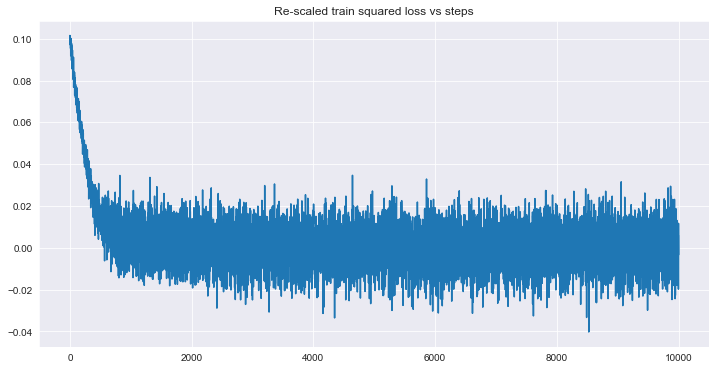

In [24]:
figure = plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(losses)), losses)
plt.title('Re-scaled train squared loss vs steps')
plt.show()

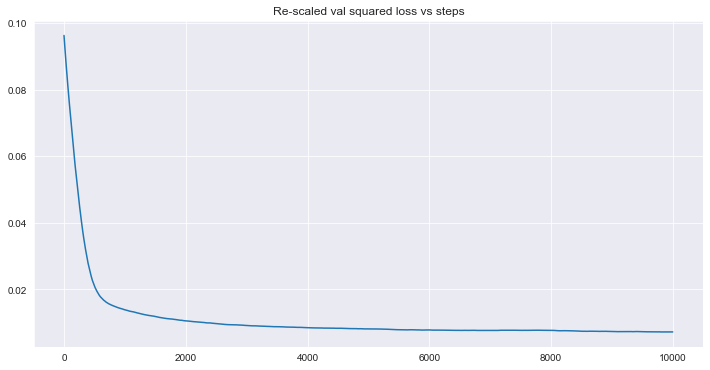

In [25]:
figure = plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Re-scaled val squared loss vs steps')
plt.show()

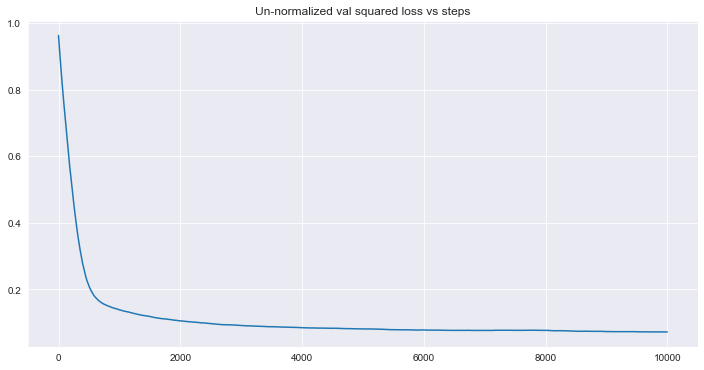

In [26]:
figure = plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(val_losses)), input_dim * np.array(val_losses))
plt.title('Un-normalized val squared loss vs steps')
plt.show()

In [27]:
thetas_plus = thetas[:, signs > 0]
thetas_minus = thetas[:, signs < 0]

cs_plus = cs[:, signs > 0]
cs_minus = cs[:, signs < 0]

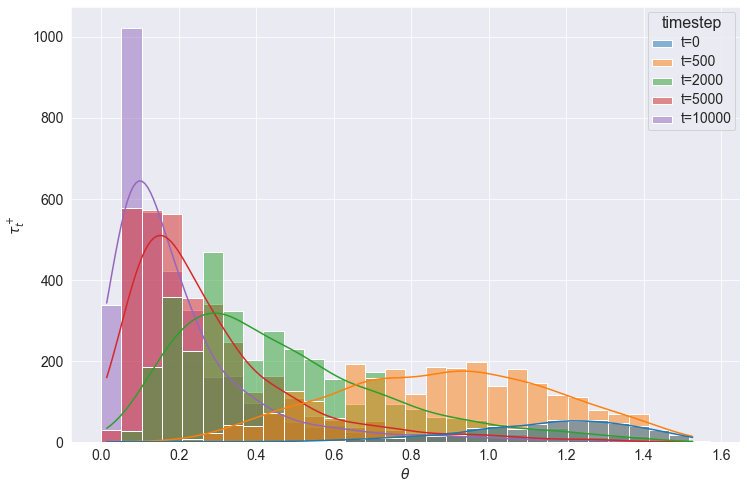

In [28]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['$\\theta$', 'timestep', 'weight'])
data['$\\theta$'] = thetas_plus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
ax = sns.histplot(data, x='$\\theta$', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
                 multiple='layer', weights='weight')
ax.set_xlabel('$\\theta$', fontsize=14)
ax.set_ylabel('$\\tau_t^+$', fontsize=14)
ax.tick_params(labelsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=16)
#plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.savefig(os.path.join(FIGURES_DIR, 'plus_hist.jpg'), bbox_inches='tight')
plt.show()

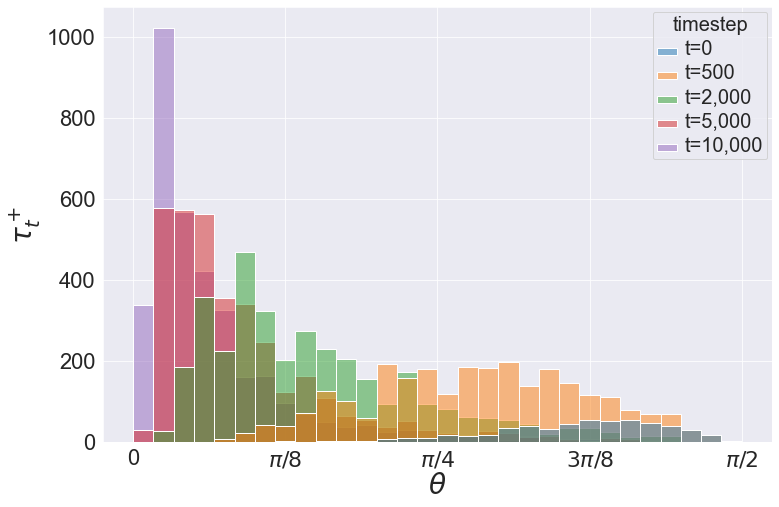

In [59]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_plus.shape[1]

data = pd.DataFrame(columns=['$\\theta$', 'timestep', 'weight'])
data['$\\theta$'] = thetas_plus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={:,}'.format(t)
    
plt.figure(figsize=(12, 8))
ax = sns.histplot(data, x='$\\theta$', hue='timestep', stat='count', kde=False, binrange=(0., np.pi/2), bins=30,
                 multiple='layer', weights='weight')
ax.set_xticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_xticklabels(['0', '$\\pi/8$', '$\\pi/4$', '$3\\pi/8$', '$\\pi/2$'])
ax.set_xlabel('$\\theta$', fontsize=28)
ax.set_ylabel('$\\tau_t^+$', fontsize=28)
ax.tick_params(labelsize=22)
plt.setp(ax.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20)
#plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.savefig(os.path.join(FIGURES_DIR, 'plus_hist.jpg'), bbox_inches='tight')
plt.show()

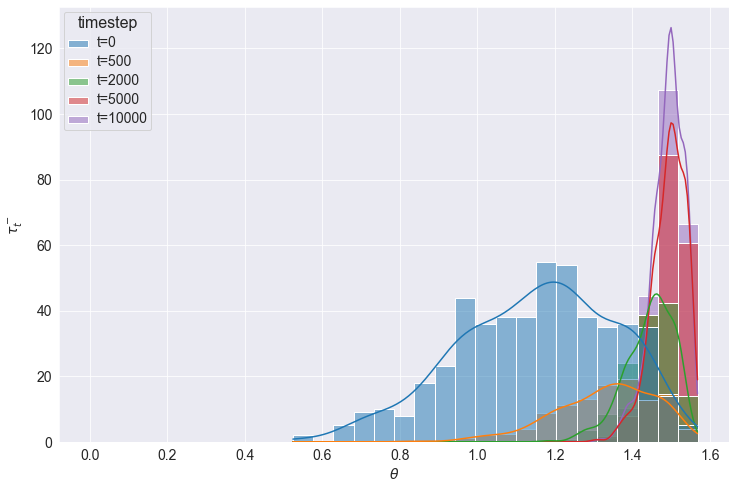

In [29]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)

plt.figure(figsize=(12, 8))
ax = sns.histplot(data, x='theta', hue='timestep', stat='count', kde=True, binrange=(0., np.pi/2), bins=30,
                 multiple='layer', weights='weight')
ax.set_xlabel('$\\theta$', fontsize=14)
ax.set_ylabel('$\\tau_t^-$', fontsize=14)
ax.tick_params(labelsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize=14) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=16)
#plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.savefig(os.path.join(FIGURES_DIR, 'minus_hist.jpg'), bbox_inches='tight')
plt.show()

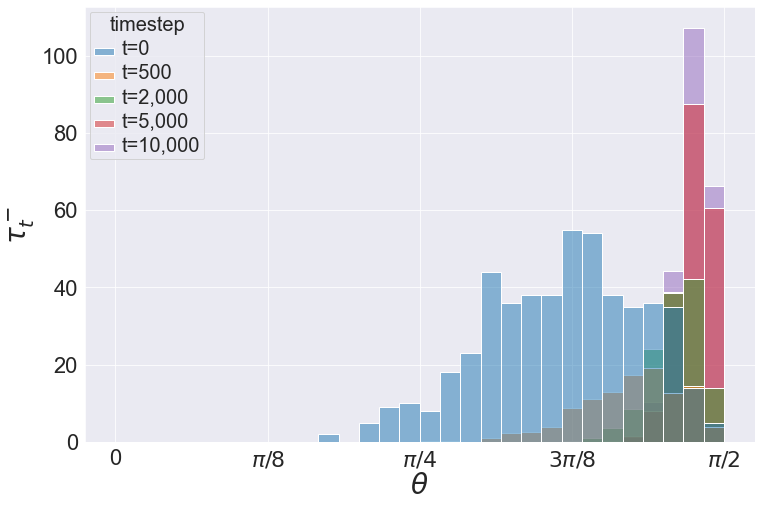

In [76]:
# ts = [0, 100, 500, 1000, 2000, 3000, 5000, 8000, 10000]
ts = [0, 500, 2000, 5000, 10000]
N = thetas_minus.shape[1]

data = pd.DataFrame(columns=['theta', 'timestep', 'weight'])
data['theta'] = thetas_minus[ts, :].reshape(-1)
data['weight'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={:,}'.format(t)

plt.figure(figsize=(12, 8))
ax = sns.histplot(data, x='theta', hue='timestep', stat='count', kde=False, binrange=(0., np.pi/2), bins=30,
                 multiple='layer', weights='weight')
ax.set_xticks([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
ax.set_xticklabels(['0', '$\\pi/8$', '$\\pi/4$', '$3\\pi/8$', '$\\pi/2$'])
ax.set_xlabel('$\\theta$', fontsize=28)
ax.set_ylabel('$\\tau_t^-$', fontsize=28)
ax.tick_params(labelsize=22)
plt.setp(ax.get_legend().get_texts(), fontsize=20) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20)
#plt.title('Distribution of the angles $\\theta$ wiht $H$ for + particles')
plt.savefig(os.path.join(FIGURES_DIR, 'minus_hist.jpg'), bbox_inches='tight')
plt.show()

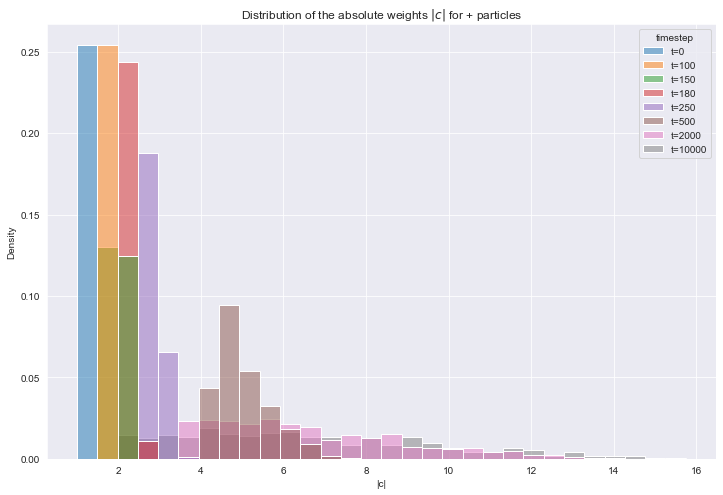

In [30]:
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_plus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_plus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=30,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for + particles')
plt.show()

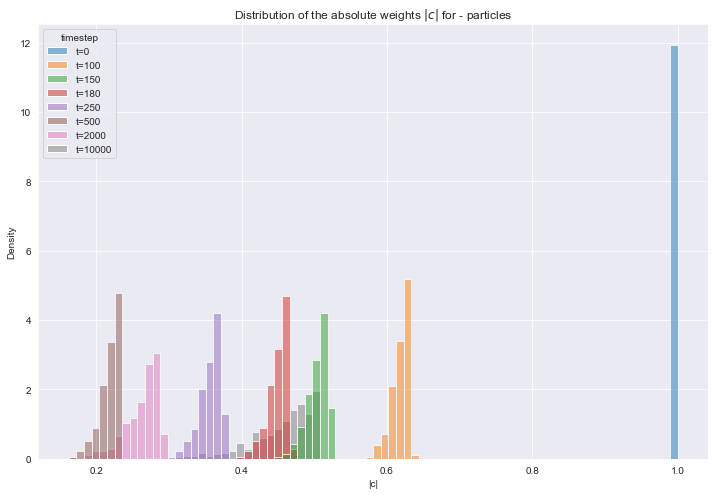

In [31]:
#ts = [0, 50, 100, 150, 180, 250, 300, 500, 1000, 2000, 5000, 8000, 10000]
ts = [0, 100, 150, 180, 250, 500, 2000, 10000]
N = cs_minus.shape[1]

data = pd.DataFrame(columns=['|c|', 'timestep'])
data['|c|'] = np.abs(cs_minus[ts, :].reshape(-1))
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='|c|', hue='timestep', stat='density', kde=False, bins=80,
             multiple='layer')
plt.title('Distribution of the absolute weights $|c|$ for - particles')
plt.savefig('/Users/karlhajjar/Downloads/minus_hist.jpg')
plt.show()

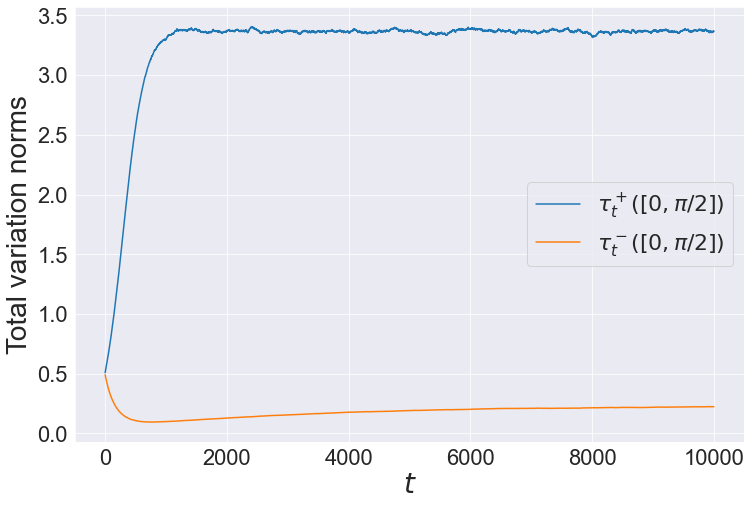

In [61]:
plus_variation_norms = np.sum(cs_plus, axis=1) / width
minus_variation_norms = np.sum(np.abs(cs_minus), axis=1)  / width
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(plus_variation_norms)), plus_variation_norms, label='$\\tau_t^+([0, \\pi/2])$')
plt.plot(np.arange(len(minus_variation_norms)), minus_variation_norms, label='$\\tau_t^-([0, \\pi/2])$')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('Total variation norms', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.savefig(os.path.join(FIGURES_DIR, 'var_norms.jpg'), bbox_inches='tight')
plt.show()

To compute the Wasserstein-$p$ distance between $\tau_t^+$ and $\alpha \delta_{0}$ one can use the formula:
$$W_p(\tau_t^+, \alpha \delta_{0}) = \left(\frac{\alpha}{m} \sum_{j \in J^+} c_j(t) |\theta_j(t)|^p \right)^{1/p}$$

In [34]:
def W(cs_plus, thetas_plus, p):
    alpha = 2 * np.sqrt(np.pi) * sp.gamma((d_H + 1)/2) / sp.gamma(d_H/2)
    return (alpha * np.sum(cs_plus * (thetas_plus ** p), axis=1) / width) ** (1/p)

In [35]:
def W_normalized(cs_plus, thetas_plus, p):
    alpha = 2 * np.sqrt(np.pi) * sp.gamma((d_H + 1)/2) / sp.gamma(d_H/2)
    norm_tau = np.sum(cs_plus, axis=1) / width
    return (alpha * np.sum(cs_plus * (thetas_plus ** p), axis=1) / width) ** (1/p) / norm_tau

In [36]:
Ws_1 = W(cs_plus, thetas_plus, p=1)
Ws_2 = W(cs_plus, thetas_plus, p=2)

In [37]:
Ws_1_norm = W_normalized(cs_plus, thetas_plus, p=1)
Ws_2_norm = W_normalized(cs_plus, thetas_plus, p=2)

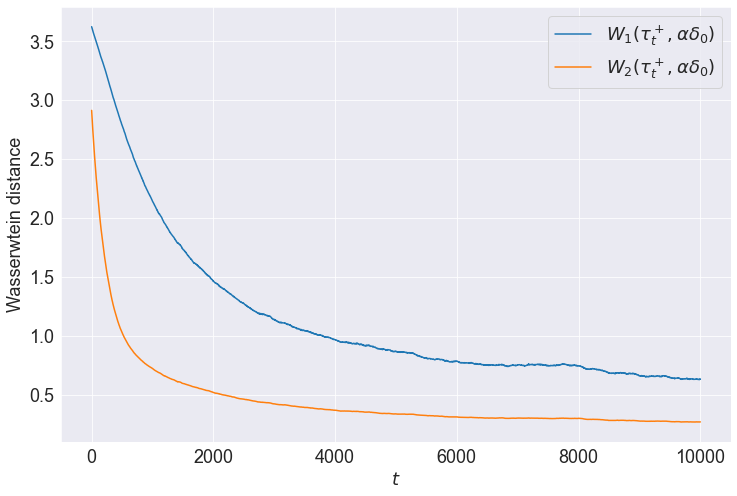

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(Ws_1)), Ws_1_norm, label='$W_1(\\tau_t^+, \\alpha \\delta_{0})$')
plt.plot(np.arange(len(Ws_2)), Ws_2_norm, label='$W_2(\\tau_t^+, \\alpha \\delta_{0})$')
plt.xlabel('$t$', fontsize=18)
plt.ylabel('Wasserwtein distance', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'W-1-2.jpg'), bbox_inches='tight')
plt.show()

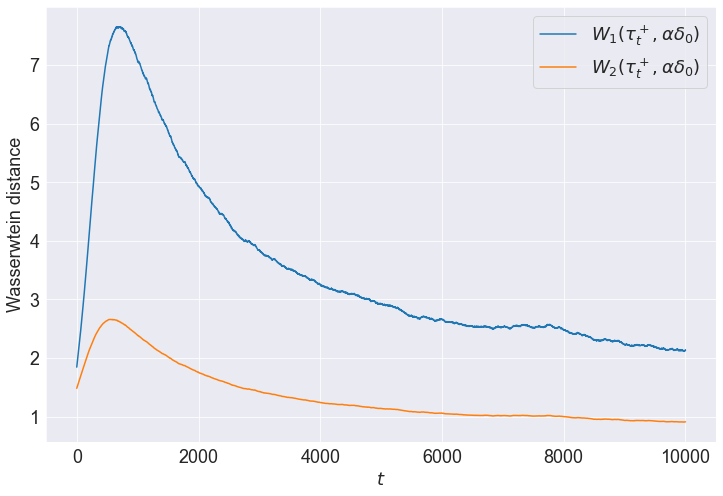

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(Ws_1)), Ws_1, label='$W_1(\\tau_t^+, \\alpha \\delta_{0})$')
plt.plot(np.arange(len(Ws_2)), Ws_2, label='$W_2(\\tau_t^+, \\alpha \\delta_{0})$')
plt.xlabel('$t$', fontsize=18)
plt.ylabel('Wasserwtein distance', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.savefig(os.path.join(FIGURES_DIR, 'W-1-2.jpg'), bbox_inches='tight')
plt.show()

To compute the Wasserstein-$p$ distance between $\tau_t^+$ and $\alpha \delta_{0}$ one can use the formula:
$$W_p(\tau_t^+, \alpha \delta_{0}) = \left(\frac{\alpha}{m} \sum_{j \in J^+} c_j(t) |\theta_j(t)|^p \right)^{1/p}$$

For $\tau_{m,t} = \frac{1}{m} \sum_{j \in J^+} c_j \delta_{\theta_j}$, the bounded-Lipschitz distance is defined as:
$$d(\tau_{m, t}, \alpha \delta_0)^2 = \frac{1}{m} \sum_{j \in J^+} c_j |\theta_j| + \frac{1}{m} \sum_{j \in J^+} |c_j -\alpha|$$
or maybe rather 
$$d(\tau_{m, t}, \alpha \delta_0)^2 = \frac{1}{m} \sum_{j \in J^+} c_j |\theta_j| + \Big| \alpha - \frac{1}{m} \sum_{j \in J^+} c_j \Big|$$

In [72]:
def bounded_lipschitz_distance(cs_plus, thetas_plus):
    alpha = 2 * np.sqrt(np.pi) * sp.gamma((d_H + 1)/2) / sp.gamma(d_H/2)
    #return np.sum(cs_plus * thetas_plus, axis=1) / width + np.sum(np.abs(cs_plus - alpha), axis=1) / width
    return np.sum(cs_plus * thetas_plus, axis=1) / width + np.abs(np.sum(cs_plus / width, axis=1) - alpha)

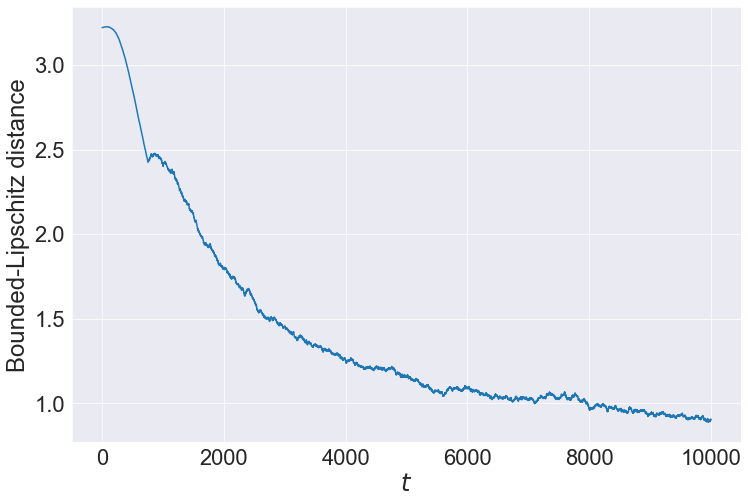

In [73]:
bounded_lip_dist = bounded_lipschitz_distance(cs_plus, thetas_plus)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(bounded_lip_dist)), bounded_lip_dist)
plt.xlabel('$t$', fontsize=24)
plt.ylabel('Bounded-Lipschitz distance', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend(fontsize=22)
#plt.savefig(os.path.join(FIGURES_DIR, 'bounded-lip.jpg'), bbox_inches='tight')
plt.show()

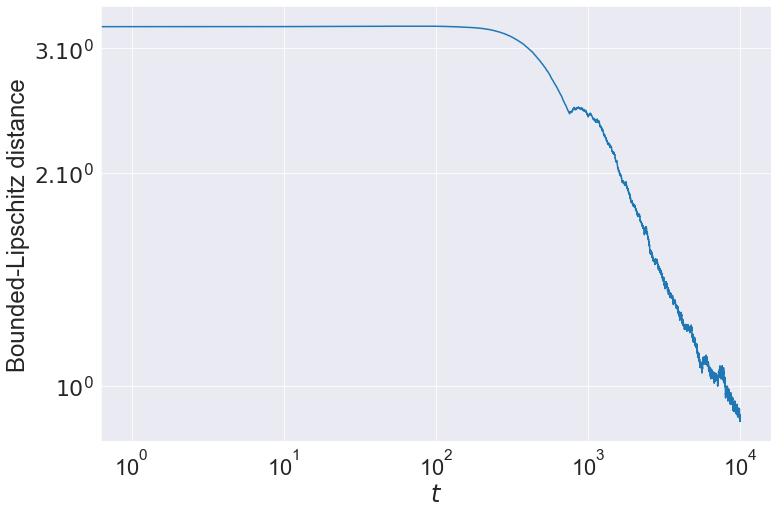

In [99]:
bounded_lip_dist = bounded_lipschitz_distance(cs_plus, thetas_plus)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(bounded_lip_dist)), bounded_lip_dist)
plt.xlabel('$t$', fontsize=24)
plt.ylabel('Bounded-Lipschitz distance', fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.yticks(ticks=[1, 2, 3], labels=['$10^0$', '$2.10^0$', '$3.10^0$'])
yticks = ax.get_yticks()
ylabels = ax.get_yticklabels()
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend(fontsize=22)
#plt.savefig(os.path.join(FIGURES_DIR, 'bounded-lip.jpg'), bbox_inches='tight')
plt.show()

In [97]:
print(yticks)
ylabels

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


[Text(0, 0.01, ''),
 Text(0, 0.1, ''),
 Text(0, 1.0, ''),
 Text(0, 10.0, ''),
 Text(0, 100.0, '')]

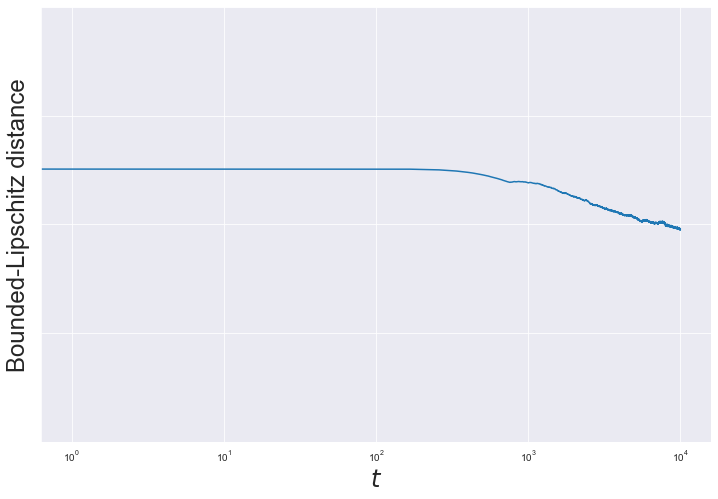

In [93]:
bounded_lip_dist = bounded_lipschitz_distance(cs_plus, thetas_plus)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(bounded_lip_dist)), bounded_lip_dist)
plt.xlabel('$t$', fontsize=24)
plt.ylabel('Bounded-Lipschitz distance', fontsize=24)
plt.yscale('log')
plt.xscale('log')
ax = plt.gca()
#ax.tick_params(labelsize=22)
#plt.xticks(fontsize=22)
#get_xticks and get_xticklabels
ax.set_yticks(ticks=ax.get_yticks())
ax.set_yticklabels(labels=ax.get_yticklabels()) # , fontdict={'fontsize': 22}
plt.yticks(fontsize=22)
#plt.legend(fontsize=22)
#plt.savefig(os.path.join(FIGURES_DIR, 'bounded-lip.jpg'), bbox_inches='tight')
plt.show()

In [87]:
ax.get_yticks()

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [88]:
ax.get_yticklabels()

[Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
 Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
 Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
 Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
 Text(0, 100.0, '$\\mathdefault{10^{2}}$')]

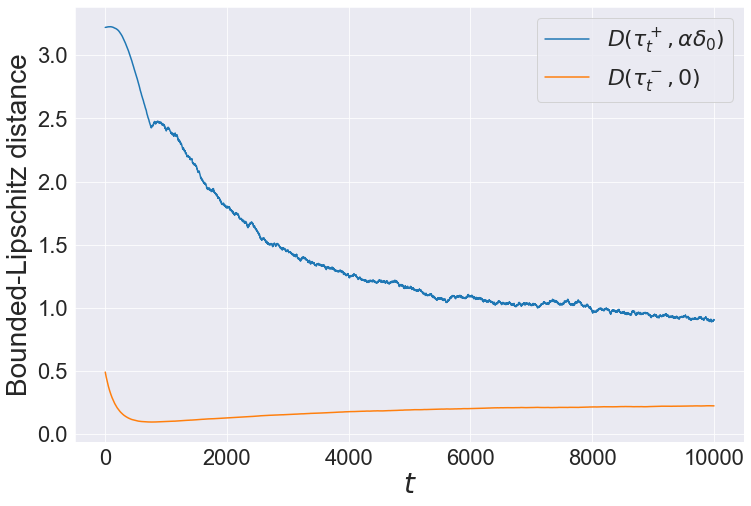

In [75]:
plus_variation_norms = np.sum(cs_plus, axis=1) / width
minus_variation_norms = np.sum(np.abs(cs_minus), axis=1)  / width
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(bounded_lip_dist)), bounded_lip_dist, label='$D(\\tau_t^+, \\alpha \\delta_0)$')
plt.plot(np.arange(len(minus_variation_norms)), minus_variation_norms, label='$D(\\tau_t^-, 0)$')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('Bounded-Lipschitz distance', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.savefig(os.path.join(FIGURES_DIR, 'bounded-lip-dist.jpg'), bbox_inches='tight')
plt.show()

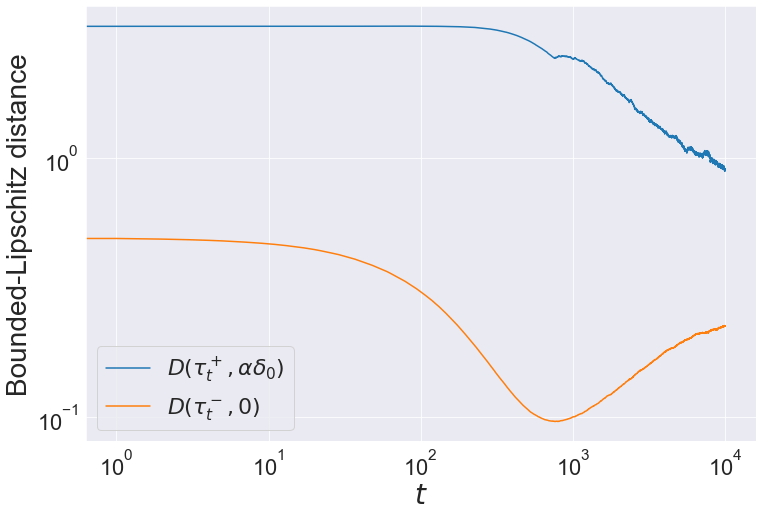

In [100]:
plus_variation_norms = np.sum(cs_plus, axis=1) / width
minus_variation_norms = np.sum(np.abs(cs_minus), axis=1)  / width
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(bounded_lip_dist)), bounded_lip_dist, label='$D(\\tau_t^+, \\alpha \\delta_0)$')
plt.plot(np.arange(len(minus_variation_norms)), minus_variation_norms, label='$D(\\tau_t^-, 0)$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('Bounded-Lipschitz distance', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
#plt.savefig(os.path.join(FIGURES_DIR, 'bounded-lip-dist.jpg'), bbox_inches='tight')
plt.show()

### Table

In [40]:
print('d =', input_dim)
print('d_H =', d_H)
print('v_th =', 2 * np.sqrt(np.pi) * sp.gamma((d_H + 1)/2) / sp.gamma(d_H/2))
print('v_exp =', np.sum(cs_plus[-1, :]) / width)

d = 10
d_H = 2
v_th = 3.1415926535897927
v_exp = 3.365958


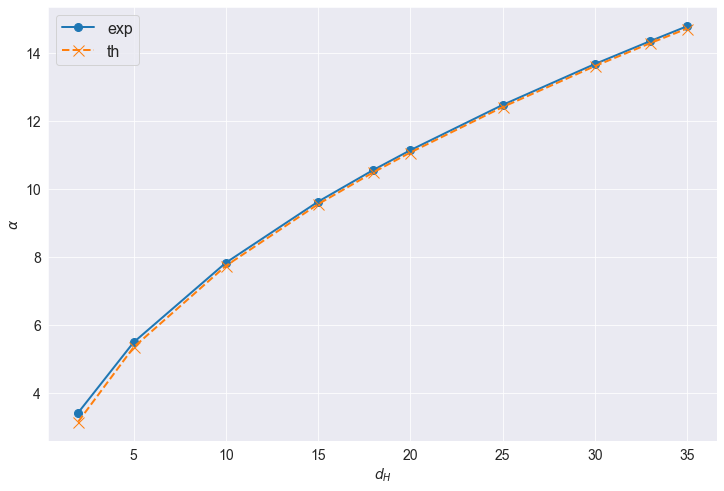

In [41]:
##### CORRECTION OF THE VALUES ######
d = 40
d_Hs = [2, 5, 10, 15, 18, 20, 25, 30, 33, 35]
v_ths = [3.141592, 5.333333, 7.731263, 9.5477785, 10.488114, 11.070787, 12.408467, 13.615453, 14.290824, 14.723880]
v_exps = [3.40828, 5.478126, 7.823118, 9.622843, 10.558362, 11.13857, 12.472371, 13.677326, 14.353262, 14.790969]

assert(len(d_Hs) == len(v_ths))
assert(len(d_Hs) == len(v_exps))


plt.figure(figsize=(12, 8))
plt.plot(d_Hs, v_exps, label='exp', marker='o', linewidth='2.', markersize=8)
plt.plot(d_Hs, v_ths, label='th', marker='x', linestyle='dashed', linewidth='2.', markersize=11)
#plt.plot(d_Hs, 2 * np.array(v_ths), label='corr_th', marker='x', linestyle='dashed')

plt.xlabel('$d_H$', fontsize=14)
plt.ylabel('$\\alpha$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, 'th-vs-exp.jpg'), bbox_inches='tight')
plt.show()

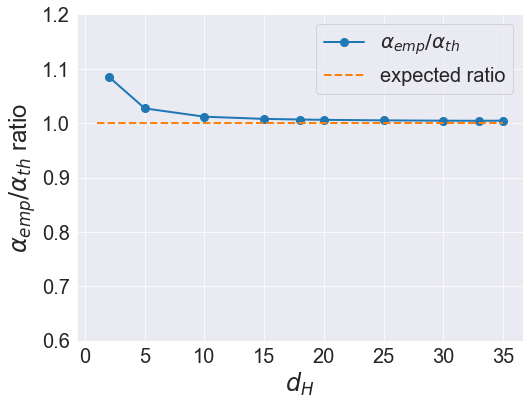

In [42]:
##### CORRECTION OF THE VALUES ######
d = 40
d_Hs = [2, 5, 10, 15, 18, 20, 25, 30, 33, 35]
v_ths = [3.141592, 5.333333, 7.731263, 9.5477785, 10.488114, 11.070787, 12.408467, 13.615453, 14.290824, 14.723880]
v_exps = [3.40828, 5.478126, 7.823118, 9.622843, 10.558362, 11.13857, 12.472371, 13.677326, 14.353262, 14.790969]

assert(len(d_Hs) == len(v_ths))
assert(len(d_Hs) == len(v_exps))


plt.figure(figsize=(8, 6))
plt.plot(d_Hs, np.array(v_exps) / np.array(v_ths), label='$\\alpha_{emp} / \\alpha_{th}$', marker='o',
         linewidth='2.', markersize=8)
plt.plot(np.arange(1, 36), 35*[1], label='expected ratio', linewidth='2.', linestyle='dashed')
#plt.plot(d_Hs, v_ths, label='th', marker='x', linestyle='dashed', linewidth='2.', markersize=11)
#plt.plot(d_Hs, 2 * np.array(v_ths), label='corr_th', marker='x', linestyle='dashed')

plt.xlabel('$d_H$', fontsize=24)
plt.ylabel('$\\alpha_{emp} / \\alpha_{th}$ ratio', fontsize=24)
plt.ylim(0.6, 1.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.savefig(os.path.join(FIGURES_DIR, 'th-vs-exp.jpg'), bbox_inches='tight')
plt.show()